In [66]:
#!/usr/bin/python
"""BigQuery I/O PySpark example."""
from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .appName('spark-bigquery-polyglot-language-demo') \
    .config('spark.jars', 'gs://spark-lib/bigquery/spark-bigquery-with-dependencies_2.12-0.25.2.jar') \
    .getOrCreate()

In [65]:
from pyspark.sql.functions import size, col, UserDefinedFunction, explode
from pyspark.sql.types import StringType
from itertools import combinations

LIMIT = 10
EXPLODE_PIE_CHART = tuple([.05] * LIMIT)

# Load data from BigQuery.
df = spark.read.format('bigquery') \
  .option('table', 'bigquery-public-data.github_repos.languages') \
  .load()

def preprocess_monorepo(arr) -> str:
    if len(arr) != 1:
        return None
    return arr[0].name

def preprocess_monorepo_size(arr) -> int:
    if len(arr) != 1:
        return 0
    return arr[0].bytes

def preprocess_polyrepo(arr) -> str:
    if len(arr) < 2:
        return None
    arr.sort(key=lambda x : -x.bytes)
    sub = arr[:3]
    sub.sort(key=lambda x : x.name)
    ret = []
    for elem in sub:
        ret.append(elem.name)
    return ', '.join(ret)

udf_map = {
    "mono_language": preprocess_monorepo,
    "mono_size": preprocess_monorepo_size,
    "poly_language": preprocess_polyrepo,
}

for name, udf in udf_map.items():
    df = df.withColumn(name, UserDefinedFunction(udf)(col("language")))
    
df.createOrReplaceTempView('df_view')
df.printSchema()
df.show()
# See the number of repositories of monoglot(single language used) and polyglot(multiple languages used).
mono = df.where(size(col("language")) == 1).count()
poly = df.where(size(col("language")) > 1).count()
print(f"The number of repositories that use only one language is {mono}")
print(f"The number of repositories that use multiple language is {poly}")

root
 |-- repo_name: string (nullable = true)
 |-- language: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- name: string (nullable = true)
 |    |    |-- bytes: long (nullable = true)
 |-- mono_language: string (nullable = true)
 |-- mono_size: string (nullable = true)
 |-- poly_language: string (nullable = true)

+--------------------+-------------+-------------+---------+-------------+
|           repo_name|     language|mono_language|mono_size|poly_language|
+--------------------+-------------+-------------+---------+-------------+
|kamilmowinski/scr...|   [{C, 250}]|            C|      250|         null|
|davidlau325/ChatRoom| [{C, 40530}]|            C|    40530|         null|
|navinsoni/Device_...| [{C, 15136}]|            C|    15136|         null|
|mcomp2010-school/...|  [{C, 2829}]|            C|     2829|         null|
|      ZekeMill/pset3|  [{C, 5906}]|            C|     5906|         null|
|     fumyuun/coffeed|  [{C, 3838}]|        

+--------------------+--------------------+-------------+---------+--------------+
|           repo_name|            language|mono_language|mono_size| poly_language|
+--------------------+--------------------+-------------+---------+--------------+
|       ursic/kotivox|[{C, 14188}, {D, ...|         null|        0|          C, D|
|  tjingrant/Nussinov| [{C, 190}, {D, 18}]|         null|        0|          C, D|
|   juanjux/scramjets|[{C, 1764}, {D, 3...|         null|        0|  C, D, Python|
|         o3o/d-notes|[{C, 580}, {D, 23...|         null|        0|C, D, Makefile|
|ville-k/stanford_...|[{C, 9687}, {M, 9...|         null|        0|  C, M, Matlab|
|oofaish/abcCellCy...|[{C, 16145}, {M, ...|         null|        0|  C, M, Matlab|
|      reshadh/mixest|[{C, 8635}, {M, 4...|         null|        0|C, Matlab, TeX|
|     cran/PermuteNGS|[{C, 5065}, {R, 1...|         null|        0|          C, R|
|         zedshaw/utu|[{C, 356283}, {R,...|         null|        0|    C, R, Ruby|
|Dis

+-------------+------+
|mono_language|   cnt|
+-------------+------+
|   JavaScript|203856|
|       Python|191107|
|         Java|183299|
|         Ruby|106329|
|          PHP| 96089|
|           C#| 57746|
|        Shell| 56174|
|           Go| 42843|
|  Objective-C| 22484|
|          C++| 21983|
|         HTML| 20728|
|            C| 16377|
|      Haskell| 15981|
|      Clojure| 12226|
|        Swift| 10898|
|        Scala| 10757|
|          CSS| 10619|
|            R|  9044|
|         Perl|  8883|
|         Rust|  8309|
+-------------+------+
only showing top 20 rows



<AxesSubplot:ylabel='cnt'>

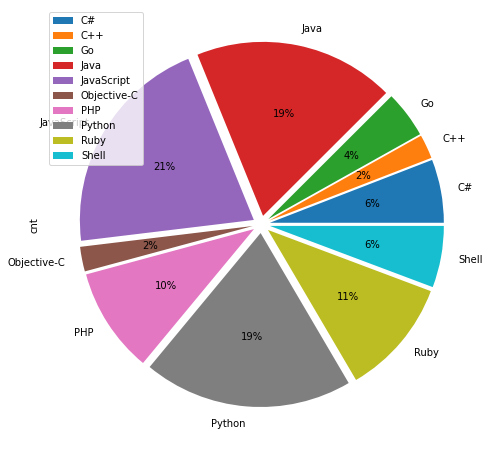

In [40]:
# Sort the monoglot repositories by the popularity of languages and see the top 10 languages.
mono_ranking = spark.sql("""
    SELECT
        df_view.mono_language,
        count(df_view.mono_language) AS `cnt`
    FROM
        df_view
    GROUP BY
        df_view.mono_language
    ORDER BY
        `cnt` DESC
""")

mono_ranking.show()
mono_panda = mono_ranking.toPandas()[:LIMIT].copy()
mono_panda.groupby(['mono_language'])
        .sum()
        .plot(
            kind='pie',
            y='cnt',
            autopct='%1.0f%%',
            figsize=(8, 8),
            explode=EXPLODE_PIE_CHART
        )

In [42]:
# Get the average size in MegaBytes of each monoglot repositories and sort by it's size
mono_ranking_avg_bytes = spark.sql("""
    SELECT
        df_view.mono_language, 
        round(avg(df_view.mono_size/1000)) AS `average(MB)`,
        count(df_view.mono_language) AS `cnt`
    FROM 
        df_view
    GROUP BY df_view.mono_language
    ORDER BY
        `average(MB)` DESC
""")
mono_ranking_avg_bytes = mono_ranking_avg_bytes.filter(col('cnt') > 100)
mono_ranking_avg_bytes.show()

+----------------+-----------+-----+
|   mono_language|average(MB)|  cnt|
+----------------+-----------+-----+
|     Mathematica|     4447.0|  244|
|Jupyter Notebook|     2224.0| 2539|
|       Pure Data|     1585.0|  132|
|           Eagle|     1322.0|  349|
|             Max|     1046.0|  112|
|           KiCad|      551.0|  266|
|            HTML|      547.0|20728|
|         PLpgSQL|      447.0|  121|
|           PLSQL|      427.0|  208|
|           Groff|      426.0|  110|
|          Pascal|      358.0| 1263|
|          AutoIt|      297.0|  266|
|       Smalltalk|      291.0|  144|
|    ActionScript|      224.0| 1420|
|              C#|      224.0|57746|
|    Visual Basic|      217.0| 2309|
|             IDL|      208.0|  146|
|          MATLAB|      178.0|  463|
|             Lua|      174.0| 7891|
|        Assembly|      165.0|  763|
+----------------+-----------+-----+
only showing top 20 rows



+--------------------+------+
|       poly_language|   cnt|
+--------------------+------+
|CSS, HTML, JavaSc...|250777|
|CSS, JavaScript, PHP| 71306|
|     CSS, JavaScript| 60494|
|    HTML, JavaScript| 53498|
|       Python, Shell| 33751|
|           CSS, HTML| 26961|
|     CSS, HTML, Ruby| 25067|
|HTML, JavaScript,...| 22135|
|   Objective-C, Ruby| 21534|
|HTML, JavaScript,...| 19858|
|         Ruby, Shell| 19756|
|CSS, JavaScript, ...| 18015|
|CSS, JavaScript, ...| 16895|
|    Assembly, C, C++| 14932|
|              C, C++| 13912|
|      CSS, HTML, PHP| 13058|
|CSS, Java, JavaSc...| 13025|
|      C, C++, Python| 12873|
|   CSS, HTML, Python| 12725|
|         Java, Shell| 11968|
+--------------------+------+
only showing top 20 rows



<AxesSubplot:ylabel='cnt'>

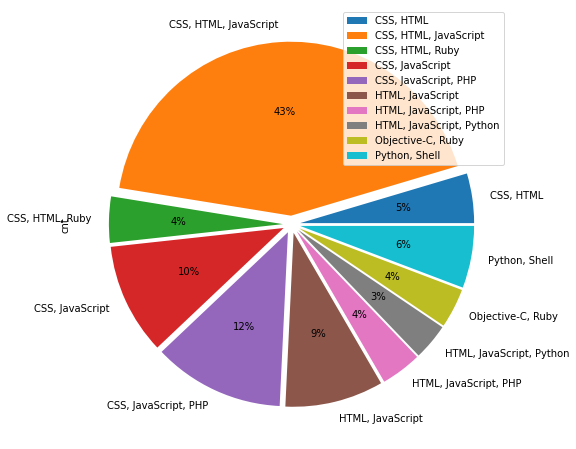

In [431]:
poly_ranking = spark.sql("""
    SELECT
        df_view.poly_language,
        count(df_view.poly_language) AS cnt
    FROM
        df_view
    GROUP BY df_view.poly_language
    ORDER BY
        cnt DESC
""")
poly_ranking.show()

poly_panda = poly_ranking.toPandas()[:LIMIT].copy()
poly_panda.groupby(['poly_language'])
        .sum()
        .plot(
            kind='pie',
            y='cnt',
            autopct='%1.0f%%',
            figsize=(8, 8),
            explode=EXPLODE_PIE_CHART
        )

In [49]:
from pyspark.sql.types import ArrayType, FloatType, StringType

def preprocess_reduce_language(arr):
    return [i.name for i in arr]

def preprocess_combination(arr):
    arr_combinations = []
    for combination in combinations(arr, 2):
        arr_combinations.append(combination)
        arr_combinations.append(combination[::-1])
    return arr_combinations


df = df.withColumn(
        "reduced_languages",
        UserDefinedFunction(
            preprocess_reduce_language,
            ArrayType(StringType())
        )(col("language"))
    )
df = df.withColumn(
        "combinations",
        UserDefinedFunction(
            preprocess_combination, 
            ArrayType(ArrayType(StringType()))
        )(col("reduced_languages"))
    )

df_new = df.select(col("repo_name"), col("combinations")).where(col("poly_language").isNotNull())
df_new = df_new.withColumn("languages", F.explode(col("combinations")))
df_new = df_new.withColumn("lang0", F.col('languages')[0])
df_new = df_new.withColumn("lang1", F.col('languages')[1])
df_new = df_new.crosstab("lang0", "lang1")
df_new.createOrReplaceTempView('df_new_view')
df_new.explain()

== Physical Plan ==
LocalTableScan [lang0_lang1#6140, 1C Enterprise#7568L, ABAP#7569L, AGS Script#7570L, AIDL#7571L, AL#7572L, AMPL#7573L, ANTLR#7574L, API Blueprint#7575L, APL#7576L, ASL#7577L, ASP#7578L, ASP.NET#7579L, ATS#7580L, ActionScript#7581L, Ada#7582L, Agda#7583L, Alloy#7584L, AngelScript#7585L, ApacheConf#7586L, Apex#7587L, AppleScript#7588L, Arc#7589L, Arduino#7590L, ... 452 more fields]




In [58]:
py_df = spark.sql('''
    SELECT lang0_lang1, `C++` from df_new_view ORDER BY `C++` DESC LIMIT 20
''')

py_df.show()

+-------------+------+
|  lang0_lang1|   C++|
+-------------+------+
|            C|182053|
|        Shell|133209|
|     Makefile| 97912|
|       Python| 96561|
|  Objective-C| 74869|
|        CMake| 49992|
|   JavaScript| 47079|
|         Perl| 46596|
|         HTML| 45648|
|     Assembly| 40439|
|          CSS| 39719|
|         Java| 32456|
|    Batchfile| 29680|
|         Ruby| 22703|
|          PHP| 18368|
|           C#| 17860|
|          Awk| 17827|
|        QMake| 17012|
|        Groff| 16640|
|Objective-C++| 15968|
+-------------+------+



In [ ]:
# fcore = single.where(col('repo_name')=="Frankenhooker/FCore")
# fcore.select(col("repo_name"), col("language"), size(col("language"))).show()

# #standardSQL
# SELECT repo_name, elem.name, elem.bytes
# FROM `github_activity_data.languages`, UNNEST(language) as elem
# WHERE 
# ORDER BY elem.bytes DESC


# spark.sql('SELECT DISTINCT repo_name, language FROM single_view').show()
# single.withColumn("test", explode($"language")).show

# print(single, poly)
# print(_all, single, poly)
# single = df.select(col("repo_name"), col("language"), size(col("language"))
#     )
# single.show()
# df.groupBy(size(col("language"))).show()
# test_words.printSchema()

# Saving the data to BigQuery
# word_count.write.format('bigquery') \
#   .option('table', 'wordcount_dataset.wordcount_output') \
#   .save()


# Using UDF(User Defined Function), the actual plan is following.
# Create a new column named “dominant_language: string”.
# If len(language) == 0:
# dominant_language = null and drop the row.
# Else if len(language) == 1:
# dominant_language = language.name.
# Else if len(language) > 1:
# iterate the array
# Ignore languages if the percentage is less than 10%
# Choose top 3 languages in a repo to make a group
# In this case, these top 3 languages will not categorize well. Most of the combination of languages will be the part of web development.

# Instead of choose top 3 languages to group them, 


In [202]:
import pandas as pd
  
# DataFrame of each student and the votes they get
dataframe = pd.DataFrame({'Name': ['Aparna', 'Aparna', 'Aparna', 
                                   'Aparna', 'Aparna', 'Juhi', 
                                   'Juhi', 'Juhi', 'Juhi', 'Juhi',
                                   'Suprabhat', 'Suprabhat', 
                                   'Suprabhat', 'Suprabhat', 
                                   'Suprabhat'],
                          'votes_of_each_class': [12, 9, 17, 19, 
                                                  20, 11, 15, 12, 
                                                  9, 4, 22, 19, 17, 
                                                  19, 18]})
  
# Plotting the pie chart for above dataframe
print(dataframe.groupby(['Name']).sum())

           votes_of_each_class
Name                          
Aparna                      77
Juhi                        51
Suprabhat                   95


In [574]:
from pyspark.sql import functions as F
df = spark.createDataFrame(
    [('aa', [["dog"], ["cat"], ["lizard"]]),
     ('bb', [["dog"], ["spider"]]),
     ('cc', [["dog"], ["cat"], ["monkey"]])],
    ['user', 'pets'])


df = df.withColumn('pets', F.flatten('pets'))

df.show()
combinations = (F.filter(
    F.transform(
        F.flatten(F.transform(
            'pets',
            lambda x: F.arrays_zip(F.array_repeat(x, F.size('pets')), 'pets')
        )),
        lambda x: F.array(x['0'], x['pets'])
    ),
    lambda x: x[0] < x[1]
))
df = df.withColumn('pets', F.explode(combinations))
df.show()
df = df.withColumn('pet0', F.col('pets')[0])
df = df.withColumn('pet1', F.col('pets')[1])

df = df.crosstab("pet0", "pet1")

df.show()


+----+------------------+
|user|              pets|
+----+------------------+
|  aa|[dog, cat, lizard]|
|  bb|     [dog, spider]|
|  cc|[dog, cat, monkey]|
+----+------------------+

+----+-------------+
|user|         pets|
+----+-------------+
|  aa|[dog, lizard]|
|  aa|   [cat, dog]|
|  aa|[cat, lizard]|
|  bb|[dog, spider]|
|  cc|[dog, monkey]|
|  cc|   [cat, dog]|
|  cc|[cat, monkey]|
+----+-------------+

+---------+---+------+------+------+
|pet0_pet1|dog|lizard|monkey|spider|
+---------+---+------+------+------+
|      cat|  2|     1|     1|     0|
|      dog|  0|     1|     1|     1|
+---------+---+------+------+------+



In [15]:
from pyspark.sql.functions import explode_outer, flatten, transform, arrays_zip, array_repeat, size, array
from pyspark.sql import functions as F
import itertools

languages = df.select(df.repo_name, explode_outer(df.language['name']) \
                .alias("language")) \
                .distinct() \
                .filter(col("language") \
                .isNotNull())
# test = df.select(df.repo_name, explode_outer(df.language['name']).alias("language")).where(df.repo_name=='iloveG/APM').show()
languages.show()
languages = languages.select(df.repo_name, F.join(''.col("language"),",").alias("language"))

# combinations = (F.filter
#                     (F.transform
#                          (F.flatten
#                               (F.transform('language', 
#                                        lambda x: F.arrays_zip(F.array_repeat(x, F.size('language')), 
#                                        'language'))), 
#                          lambda x: F.array(x['0'], x['language'])), 
#                      lambda x: x[0] < x[1]))

# languages = languages.withColumn('language', F.explode(combinations))

# languages = languages.withColumn('language', F.explode(combinations))
# languages = languages.withColumn('language0', F.col('language')[0])
# languages = languages.withColumn('language1', F.col('language')[1])

# languages = languages.crosstab("language0", "language1")

# languages.show()
# languages.count()

+--------------------+-----------+
|           repo_name|   language|
+--------------------+-----------+
|   modocache/color.c|          C|
|ADN-DevTech/3dsMa...|        C++|
|   ufna/VaOcean-Demo|          C|
|avalonfr/avalon_c...|        PHP|
|    soumith/fbthrift|      Shell|
|ss13remake/msprit...|         C#|
|KeyboardFire/cave...| JavaScript|
|aquiatanelvin13/j...|         EQ|
|orangeduck/CPP_CO...|          C|
|      evaleev/dynamo|        C++|
|    robomq/robomq.io|     Python|
|r-o-k-u-r-o-u/Alg...|       Ruby|
|        lvu/rtf2html|   Makefile|
|     paperclip/talpa|      Shell|
|      edombowsky/tig|          C|
|liberalcoin/liber...|        IDL|
|chriswongtv/Grand...|Objective-C|
|  jindulys/Wikipedia|   Makefile|
| hgl888/chromium-efl|      Shell|
| astraycat/astraybot|      Groff|
+--------------------+-----------+
only showing top 20 rows



AttributeError: module 'pyspark.sql.functions' has no attribute 'join'